In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.linear_model import LinearRegression

In [2]:
# Get the data
qqq = yf.download(tickers="QQQ", period="24h", interval="1m")
btc = yf.download(tickers="BTC-USD", period="24h", interval="1m")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
df = qqq.merge(btc,how="inner", left_on="Datetime", right_on="Datetime", suffixes=["_qqq","_btc"])
print(df.tail())

                             Open_qqq    High_qqq     Low_qqq   Close_qqq  \
Datetime                                                                    
2022-04-28 15:54:00-04:00  327.619995  327.970001  327.440002  327.619995   
2022-04-28 15:55:00-04:00  327.619995  327.619995  326.980011  327.049988   
2022-04-28 15:57:00-04:00  327.274994  327.450012  327.190002  327.385010   
2022-04-28 15:58:00-04:00  327.375000  327.549988  327.290009  327.420105   
2022-04-28 15:59:00-04:00  327.410004  328.079987  327.309998  327.929993   

                           Adj Close_qqq  Volume_qqq      Open_btc  \
Datetime                                                             
2022-04-28 15:54:00-04:00     327.619995      471538  39961.671875   
2022-04-28 15:55:00-04:00     327.049988      461269  39955.113281   
2022-04-28 15:57:00-04:00     327.385010      368311  39952.386719   
2022-04-28 15:58:00-04:00     327.420105      658858  39948.507812   
2022-04-28 15:59:00-04:00     327.929993

In [4]:
y1 = df['Close_qqq']
y2 = df['Close_btc']
y1 = (y1 - np.mean(y1)) / np.std(y1)
y2 = (y2 - np.mean(y2)) / np.std(y2)

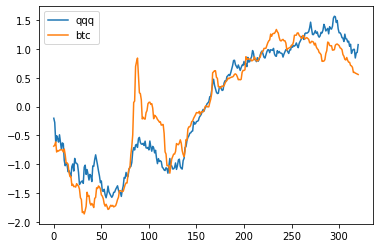

In [5]:
plt.plot(range(len(y1)),y1, label="qqq")
plt.plot(range(len(y2)),y2, label="btc")
plt.legend()

In [6]:
def max_offset(df1, df2):
#     print(len(df1), len(df2))
    corrs = signal.correlate(df1, df2, mode='full')
    return np.argmax(corrs) - len(df1) + 1, corrs[np.argmax(corrs)]
print(max_offset(y1,y2))

(0, 300.3490086978951)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


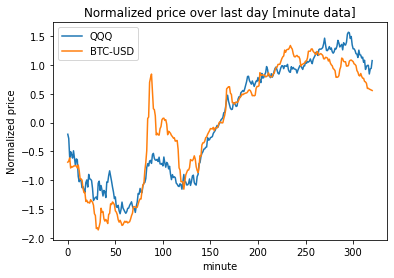

(0, 300.3490086978951)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


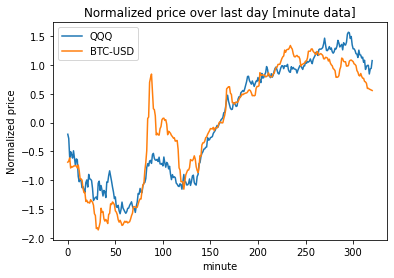

0     -0.202666
1     -0.276534
2     -0.608933
3     -0.506050
4     -0.556175
         ...   
316    0.995050
317    0.844674
318    0.933057
319    0.942316
320    1.076831
Name: Close_a, Length: 321, dtype: float64 0     -0.688578
1     -0.668356
2     -0.614136
3     -0.789372
4     -0.764246
         ...   
316    0.597063
317    0.581233
318    0.574653
319    0.565291
320    0.557767
Name: Close_b, Length: 321, dtype: float64
(0, 2850.2451967065535, [(0.0038120320248147335, 0), (0.01996565913960284, 15), (0.016159500352959454, 30), (0.007710894269349483, 45), (0.04966444114230372, 60), (0.02493819153058443, 75), (0.006564887079924888, 90), (0.01708675848276716, 105), (5.776892937360903e-05, 120), (0.006808261847397867, 135), (0.0010689462176861168, 150), (0.014154489880025899, 165), (0.0026442662492189625, 180), (0.007792110941625241, 195), (0.014825396909382567, 210), (0.008139383071747774, 225), (0.010392667057702209, 240), (0.022924403247249113, 255), (0.007232426060843389, 

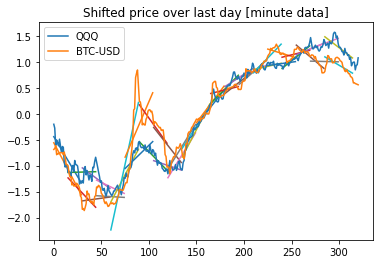

In [7]:
def ticker_offset(str1, str2, silent=False):
    a = yf.download(tickers=str1, period="24h", interval="1m")
    b = yf.download(tickers=str2, period="24h", interval="1m")
    df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime", suffixes=["_a","_b"])
    y1 = df['Close_a']
    y2 = df['Close_b']
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)
    if not silent:
        plt.plot(range(len(y1)),y1, label=str1)
        plt.plot(range(len(y2)),y2, label=str2)
        plt.legend()
        plt.title("Normalized price over last day [minute data]")
        plt.ylabel("Normalized price")
        plt.xlabel("minute")
        plt.show()
    return max_offset(y1,y2)

def ticker_offset_slope_loss(str1, str2, silent=False):
    a = yf.download(tickers=str1, period="24h", interval="1m")
    b = yf.download(tickers=str2, period="24h", interval="1m")
    df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime", suffixes=["_a","_b"])
    y1 = df['Close_a']
    y2 = df['Close_b']
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)
    if not silent:
        plt.plot(range(len(y1)),y1, label=str1)
        plt.plot(range(len(y2)),y2, label=str2)
        plt.legend()
        plt.title("Normalized price over last day [minute data]")
        plt.ylabel("Normalized price")
        plt.xlabel("minute")
        plt.show()
    offset = max_offset(y1,y2)[0]
    b["Datetime_shift"] = b.index + pd.Timedelta(minutes=offset)
    shift_df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime_shift", suffixes=["_a","_b"])
    y1 = shift_df['Close_a']
    y2 = shift_df['Close_b']
    y1_original = y1[:]
    y2_original = y2[:]
    
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)
    print(y1, y2)
    f, ax = plt.subplots()
    def slope_loss(k, s):
        diffs = []
        for i in range(0, len(y1)-k, s):
            xs = np.array(range(i, i+k)).reshape(-1, 1)
            line1 = LinearRegression().fit(xs, y1[i:i+k])
            starty = line1.predict([xs[0]])
            endy = line1.predict([xs[-1]])
            ax.plot([xs[0], xs[-1]], [starty, endy])
            reg1 = line1.coef_[0]
            #print("Slope 1 ", reg1)
            line2 = LinearRegression().fit(xs, y2[i:i+k])
            reg2 = line2.coef_[0]
            starty = line2.predict([xs[0]])
            endy = line2.predict([xs[-1]])
            ax.plot([xs[0], xs[-1]], [starty, endy])
            #print("Slope 2", reg2)
#             print(type(xs[0]))
            diffs.append((abs(reg1-reg2), list(xs[0])[0]))
#             if i*s < len(y1)-k: 
#                 print(shift_df.iloc[i * s, :])
#         print(np.where(shift_df[shift_df[]))

        #print(diffs)
        return np.sum(diffs), diffs
        
    total_slope_loss, diffs = slope_loss(30, 15)
    if not silent:
        ax.plot(range(len(y1)),y1, label=str1)
        ax.plot(range(len(y2)),y2, label=str2)
        ax.legend()
        ax.set_title("Shifted price over last day [minute data]")
        #ax.ylabel("Normalized price")
        #ax.xlabel("minute")
        #ax.show()
    return offset, total_slope_loss, diffs, y1_original, y2_original
print(ticker_offset("QQQ","BTC-USD"))
print(ticker_offset_slope_loss("QQQ","BTC-USD")[:3])



In [10]:
## Early ticker offset does not plot and only uses the 
# first half of the data to find the shift for correlation

def early_ticker_offset(str1, str2):
    a = yf.download(tickers=str1, period="48h", interval="1m", progress=False)
    b = yf.download(tickers=str2, period="48h", interval="1m", progress=False)
    df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime", suffixes=["_a","_b"])
    
    ## Use only the first half of the day
    df = df[:len(df)//2]
    y1 = df['Close_a']
    y2 = df['Close_b']
    y1_original = y1[:]
    y2_original = y2[:]
    
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)

    offset = max_offset(y1,y2)[0]
    b["Datetime_shift"] = b.index + pd.Timedelta(minutes=offset)
    shift_df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime_shift", suffixes=["_a","_b"])
    y1 = shift_df['Close_a'][:len(df)//2]
    y2 = shift_df['Close_b'][:len(df)//2]
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)
    
    def slope_loss(k, s):
        diffs = []
        for i in range(0,len(y1)-k, s):
            xs = np.array(range(i,i+k)).reshape(-1, 1)
            line1 = LinearRegression().fit(xs, y1[i:i+k])
            starty = line1.predict([xs[0]])
            endy = line1.predict([xs[-1]])

            reg1 = line1.coef_[0]
            #print("Slope 1 ", reg1)
            line2 = LinearRegression().fit(xs, y2[i:i+k])
            reg2 = line2.coef_[0]
            starty = line2.predict([xs[0]])
            endy = line2.predict([xs[-1]])

            #print("Slope 2", reg2)
            diffs.append((abs(reg1-reg2), list(xs[0])[0]))
        #print(diffs)
        return np.sum(diffs), diffs
        
    total_slope_loss, diffs = slope_loss(30, 15)
    return offset, total_slope_loss, diffs, y1_original, y2_original


token_diffs = {}
y1y2_original = {}
tokens = ["QQQ", "BTC-USD", "ETH-USD", "USDT-USD", "BNB-USD", "USDC-USD", "XRP-USD", "LUNA1-USD", "ADA-USD", "ALGO-USD", "XRP-USD", "LUNA1-USD", "ADA-USD", "HEX-USD", "AVAX-USD", "DOGE-USD"] # 
offset_matrix = {}

for idx1, token1 in enumerate(tokens):
    for idx2, token2 in enumerate(tokens):
        offset, sl, diffs, y1, y2 = early_ticker_offset(token1, token2)
        pair_symbol = token1 + token2
#         print(pair_symbol)
        offset_matrix[pair_symbol] = offset
        token_diffs[pair_symbol] = diffs
        y1y2_original[pair_symbol] = (y1, y2)
#         print(offset_matrix, token_diffs, y1y2_original)
        ##filter for time shifts that make sense and that we can use
        # 15min shift is the limit we picked, and <0 so we can use it to trade
        if -15<offset<0:
            print(token1, token2, offset, "slope loss", sl, diffs)

QQQ XRP-USD -1 slope loss 225.14987640143391 [(0.009457908724628386, 0), (0.018800964059548064, 15), (0.06833016406849655, 30), (0.021792354810632547, 45), (0.022786329611721404, 60), (0.008708680158894455, 75)]
QQQ LUNA1-USD -1 slope loss 225.1707693175446 [(0.0027481927481364937, 0), (0.0112099849781582, 15), (0.08269964454967531, 30), (0.029295717622989683, 45), (0.04411550731112413, 60), (0.0007002703345473371, 75)]
QQQ ADA-USD -1 slope loss 315.2559290613903 [(0.03372893337130982, 0), (0.014134826829273361, 15), (0.06005757399123722, 30), (0.04887366327701472, 45), (0.030503635269622114, 60), (0.002035182205147954, 75), (0.06659524644668703, 90)]
QQQ XRP-USD -1 slope loss 225.14987640143391 [(0.009457908724628386, 0), (0.018800964059548064, 15), (0.06833016406849655, 30), (0.021792354810632547, 45), (0.022786329611721404, 60), (0.008708680158894455, 75)]
QQQ LUNA1-USD -1 slope loss 225.1707693175446 [(0.0027481927481364937, 0), (0.0112099849781582, 15), (0.08269964454967531, 30), 

USDC-USD AVAX-USD -2 slope loss 5670.858429310384 [(0.030348097189029137, 0), (0.034802733840436334, 15), (0.012631226248555215, 30), (0.03739965929009954, 45), (0.023179057340042795, 60), (0.03843652505807819, 75), (0.06333677700487887, 90), (0.04087598798749882, 105), (0.011702878814492505, 120), (0.03210263151251455, 135), (0.020850133312088306, 150), (0.06811616635950966, 165), (0.0155945549027315, 180), (0.0017695717252699805, 195), (0.01968135236994953, 210), (0.09301349766601165, 225), (0.019274703041141893, 240), (0.017766433977992657, 255), (0.008954163963164351, 270), (0.017760483829015013, 285), (0.07047273177669541, 300), (0.05263594253550825, 315), (0.015131295863892124, 330), (0.020572131696493398, 345), (0.06737238374120509, 360), (0.0006529707757324124, 375), (0.013788827495607175, 390), (0.010206391065983167, 405)]
USDC-USD DOGE-USD -1 slope loss 1575.5016277444533 [(0.05831590071410389, 0), (0.009136813370503514, 15), (0.01869347228808361, 30), (0.021333110301206038, 

### Our trading strategy is simply comparing ith and (i+1)th slope, if the upwards and downwards diff is greater than a certain threshold, then we buy/sell y2 at the (i+1 timestamp + offset). Given we have already shifted the timestamp and joined both crypto dataframes, I just use y2's y2_original[diffs[i+1][1]] for buy and sell. 

### NB: We paid extra attention to data leackage, i.e. not using future knowledge to trade the current stock


<BarContainer object of 169 artists>

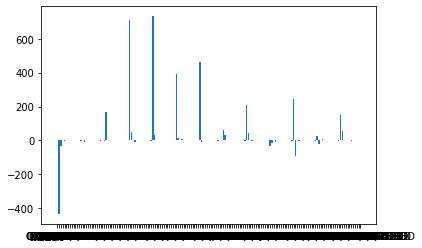

In [32]:
trading_trigger_threshold = 0.01
pair_symbols = offset_matrix.keys()
pnls = []
for pair_symbol in pair_symbols:
    offset = offset_matrix[pair_symbol] 
    diffs = token_diffs[pair_symbol]  
    y1_original, y2_original = y1y2_original[pair_symbol]    
#     print(y2_original[offset])
    pnl = 0
    hold = False
    max_timestamp = diffs[-1][1]
    for i in range(len(diffs)-1):
        if diffs[i+1][0] - diffs[i][0] > trading_trigger_threshold and hold is False: # and diffs[i+1][1]+offset < max_timestamp: # buy
            pnl -= y2_original[diffs[i+1][1]]
            hold = not hold
#             print(pnl, y2_original[diffs[i+1][1]])
        elif diffs[i][0] - diffs[i+1][0] > trading_trigger_threshold and hold is True: # and diffs[i+1][1]+offset < max_timestamp: # sell
            pnl += y2_original[diffs[i+1][1]]
            hold = not hold
#             print(pnl, y2_original[diffs[i+1][1]])
    if hold:
        pnl += y2_original[diffs[-1][1]]
    pnls.append(pnl)
#     print(pair_symbol, pnl)
       
plt.bar(pair_symbols, pnls)